## General Information

This notebook is used to train a simple neural network model to predict the chemistry in the barite benchmark (50x50 grid). The training data is stored in the repository using **git large file storage** and can be downloaded after the installation of git lfs using the `git lfs pull` command.

It is then recommended to create a Python environment using miniconda. The necessary dependencies are contained in `environment.yml` and can be installed using `conda env create -f environment.yml`.

The data set is divided into a design and result part and consists of the iterations of a reference simulation. The design part of the data set contains the chemical concentrations at time $t$ and the result part at time $t+1$, which are to be learned by the model.

## Chemical problem

In the Barite benchmark, the system is initially in equilibrium. In iteration 0, barium is added to the system at various points, causing celestite to dissolve and barium to react with the sulphates to form barite, which precipitates.

\begin{equation}
	\underbrace{Ba^{2+}_{}}_{\text{Barium}} + \underbrace{SrSO_4}_{\text{Celestite}} \rightarrow \underbrace{BaSO_4^{2-}}_{\text{Barite}} + \underbrace{Sr^{2+}_{}}_{\text{Strontium}}
\end{equation}

## Setup Libraries

All necessary preprocessing steps are outsourced to `preprocessing.py` in order to keep the notebook as compact as possible.

In [1]:
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

2025-02-26 17:33:56.161717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 17:33:56.182881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read data from `.h5` file and convert it to a `pandas.DataFrame`

Various data sets are available for training, each of which contains the PHREEQC simulation data. The data simulates the Barite benchmark, but under different starting conditions.

- `Barite_50_Data_training.h5`: Simulates a total of 1000 iterations, with barium being abandoned at one corner. The data set also contains all 1000 iterations
- `barite_50_4_corner.h5`: Simulates a total of 5000 iterations, with barium being abandoned at all 4 corners. Contains every 20th iteration.
- `barite_50_4_corner_20k.h5`: Simulates a total of 20000 iterations, whereby barium is abandoned at all 4 corners and also contains all 20000 iterations (not in the LFS, as too large for git)

The datasets are located under `./datasets` (must first be pulsed with git lfs)




| Dataset | # cells  | non-reactive portion | reactive portion |
|---------|--------------|----------------------|---------------|
| 1-corner 1k Iterations      | 2.502.500    | 0,988                | 0,012         |
| 4-corner 5k Iterations      | 630.000      | 0,952                | 0,048         |
| 4-corner 20k Iterations       | 50.000.000   | 0,867                | 0,133         |


In [2]:
# load data and differentiate between design and results (before and after a simulation step)
data_file = h5py.File("../datasets/barite_50_4_corner.h5")

design = data_file["design"]
results = data_file["result"]

df_design = pd.DataFrame(
    np.array(design["data"]).transpose(), columns=np.array(design["names"].asstr())
)
df_results = pd.DataFrame(
    np.array(results["data"]).transpose(), columns=np.array(results["names"].asstr())
)

data_file.close()

## Preprocess Data

The data are preprocessed in the following way:

1. Label data points in the `design`  dataset with `reactive` and `non-reactive` labels using kmeans clustering
2. **Optional:** Transform `design` and `results` data set into log-scaled data.
3. Split data into training and test sets.
4. Learn scaler (MinMax-Scaling or standardization) on training data for `design` and `results` together (option `global`) or individual (option `individual`).
5. Transform training and test data with the learned scaler.
6. Split training data into training and validation dataset.

The dataset contains more chemical species than we need (i.e. charge or ionized forms). That's why we need to select the species we want to train on.

In [3]:
species_columns = ["H", "O", "Ba", "Cl", "S", "Sr", "Barite", "Celestite"]

In [ ]:
preprocess = preprocessing() #np.log1p, np.expm1
X, y = preprocess.cluster(df_design[species_columns], df_results[species_columns])

# optional: perform log transformation
# X, y = preprocess.funcTranform(X, y)

X_train, X_test, y_train, y_test = preprocess.split(X, y, ratio=0.2)
X_train_origin = X_train.copy()
X_train, y_train = preprocess.balancer(X_train, y_train, strategy="off")
X_train, y_train = preprocess.class_selection(X_train, y_train, class_label=0)
preprocess.scale_fit(X_train, y_train, scaling="global", type="standard")
X_train, X_test, y_train, y_test = preprocess.scale_transform(
    X_train, X_test, y_train, y_test
)
X_train, X_val, y_train, y_val = preprocess.split(X_train, y_train, ratio=0.1)

/home/signer/bin/miniconda3/envs/training/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Amount class 0 before: 0.9521309523809524
Amount class 1 before: 0.04786904761904762
No sampling selected. Output equals input.


For a better understanding, we can first visualise the barite distribution for different iterations.

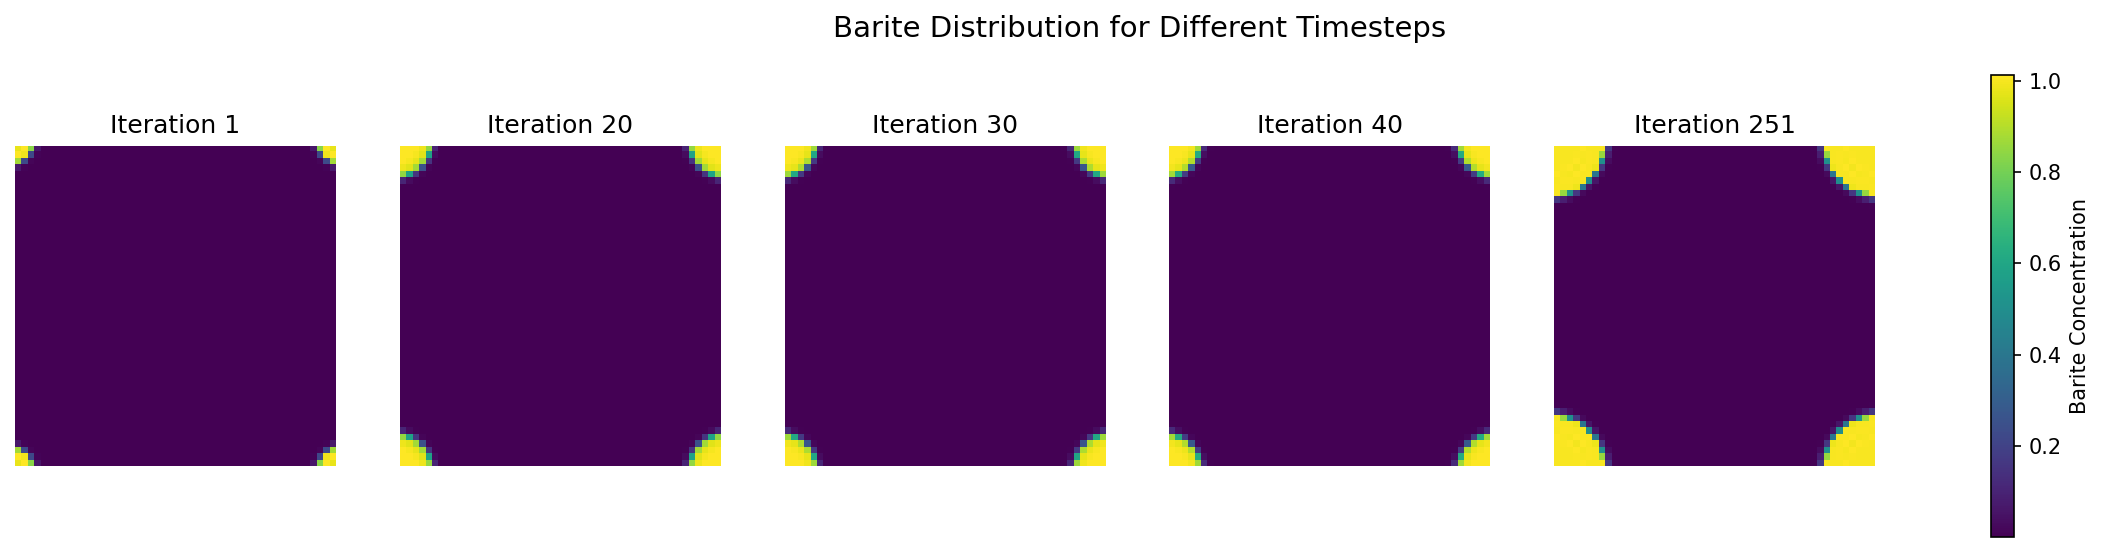

In [18]:
timesteps = [1, 20, 30, 40, 251]
fig, axes = plt.subplots(1, 5, figsize=(20, 4), dpi=150)

for i, timestep in enumerate(timesteps):
    ax = axes[i]
    im = ax.imshow(
        np.array(X["Barite"][(timestep * 2500) : (timestep * 2500 + 2500)]).reshape(
            50, 50
        ),
        origin="lower",
        cmap="viridis",
    )
    ax.set_title(f"Iteration {timestep}")
    ax.axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Barite Concentration")
plt.suptitle("Barite Distribution for Different Timesteps", fontsize=14)
plt.show()

## Train the model

Tensorflow has problems processing DataFrames in custom loss function, so that the elements cannot be called with `df.loc[:, ‘Barite’]`, but only via indices. We therefore have to extract the indices of the chemical species into a dictionary.

In [19]:
column_dict = {}
for i in species_columns:
    column_dict[i] = X.columns.get_loc(i)

In the following we define all the necessary functions and parameters that are required for training.

In [20]:
def model_training(model, batch_size=512, epochs=100):
    start = time.time()
    callback = keras.callbacks.EarlyStopping(monitor="loss", patience=30)
    history = model.fit(
        X_train.loc[:, X_train.columns != "Class"],
        y_train.loc[:, y_train.columns != "Class"],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(
            X_val.loc[:, X_val.columns != "Class"],
            y_val.loc[:, y_val.columns != "Class"],
        ),
        callbacks=[callback],
    )

    end = time.time()

    print("Training took {} seconds".format(end - start))

    return history

In [21]:
# select model architecture
model = model_definition("large")

# define learning rate adaptation
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=2000, decay_rate=0.9, staircase=True
)

# hyperparameters that are determined by hyperparameter optimization
h1 = 0.16726490480995826
h2 = 0.5283208497548787
h3 = 0.5099528144902471


scaler_type = "standard"
loss_variant = "huber_mass_balance"
delta = 1.7642791340966357


optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=custom_loss(preprocess, column_dict, h1, h2, h3, scaler_type, loss_variant, 1),
    metrics=[
        huber_metric(delta),
        mass_balance_metric(preprocess, column_dict, scaler_type),
    ],
)

In [22]:
history = model_training(model, epochs=100)

Epoch 1/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - huber: 0.0159 - loss: 0.0082 - mass_balance: 0.0116 - val_huber: 2.1637e-04 - val_loss: 0.0023 - val_mass_balance: 0.0043
Epoch 2/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - huber: 2.7016e-04 - loss: 0.0014 - mass_balance: 0.0027 - val_huber: 1.7522e-04 - val_loss: 0.0013 - val_mass_balance: 0.0025
Epoch 3/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - huber: 2.0684e-04 - loss: 0.0012 - mass_balance: 0.0022 - val_huber: 3.5211e-04 - val_loss: 0.0022 - val_mass_balance: 0.0042
Epoch 4/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - huber: 2.1493e-04 - loss: 0.0011 - mass_balance: 0.0020 - val_huber: 2.2204e-04 - val_loss: 0.0010 - val_mass_balance: 0.0019
Epoch 5/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - huber: 1.3008e-04 - loss: 7.9274e-04 - mass_balance: 0.0015 - val_huber: 4.4501e-05 - val_loss: 3.6538e-04 - val_mass_balance: 6.8946e-04
Epoch 6/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - huber: 1.1257e-04 - 

### Plot trained models

As a first visualisation step, we can plot the metrics over the epochs to display the Huber loss and the mass balance. In general, we assume that a prediction is valid if the mass balance is less than $10^{-5}$.

In [23]:
def plot_metrics(*histories):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=150)

    for history in histories:
        axes[0].plot(history.history["val_mass_balance"], label="Mass balance metric")
    axes[0].grid()
    axes[0].legend(loc="upper right", fontsize=18)
    axes[0].set_xlabel("Epoch", fontsize=18)
    axes[0].set_ylabel("Mass balance metric", fontsize=18)
    axes[0].set_title("Mass balance metric over epochs", fontsize=20, pad=15)
    axes[0].tick_params(axis="both", which="major", labelsize=16)
    axes[0].set_yscale("log")

    for history in histories:
        axes[1].plot(history.history["val_huber"], label="Huber metric")
    axes[1].grid()
    axes[1].legend(loc="upper right", fontsize=18)
    axes[1].set_xlabel("Epoch", fontsize=18)
    axes[1].set_ylabel("Huber metric", fontsize=18)
    axes[1].set_title("Huber metric over epochs", fontsize=20, pad=15)
    axes[1].tick_params(axis="both", which="major", labelsize=16)
    axes[1].set_yscale("log")

    plt.tight_layout()
    plt.show()

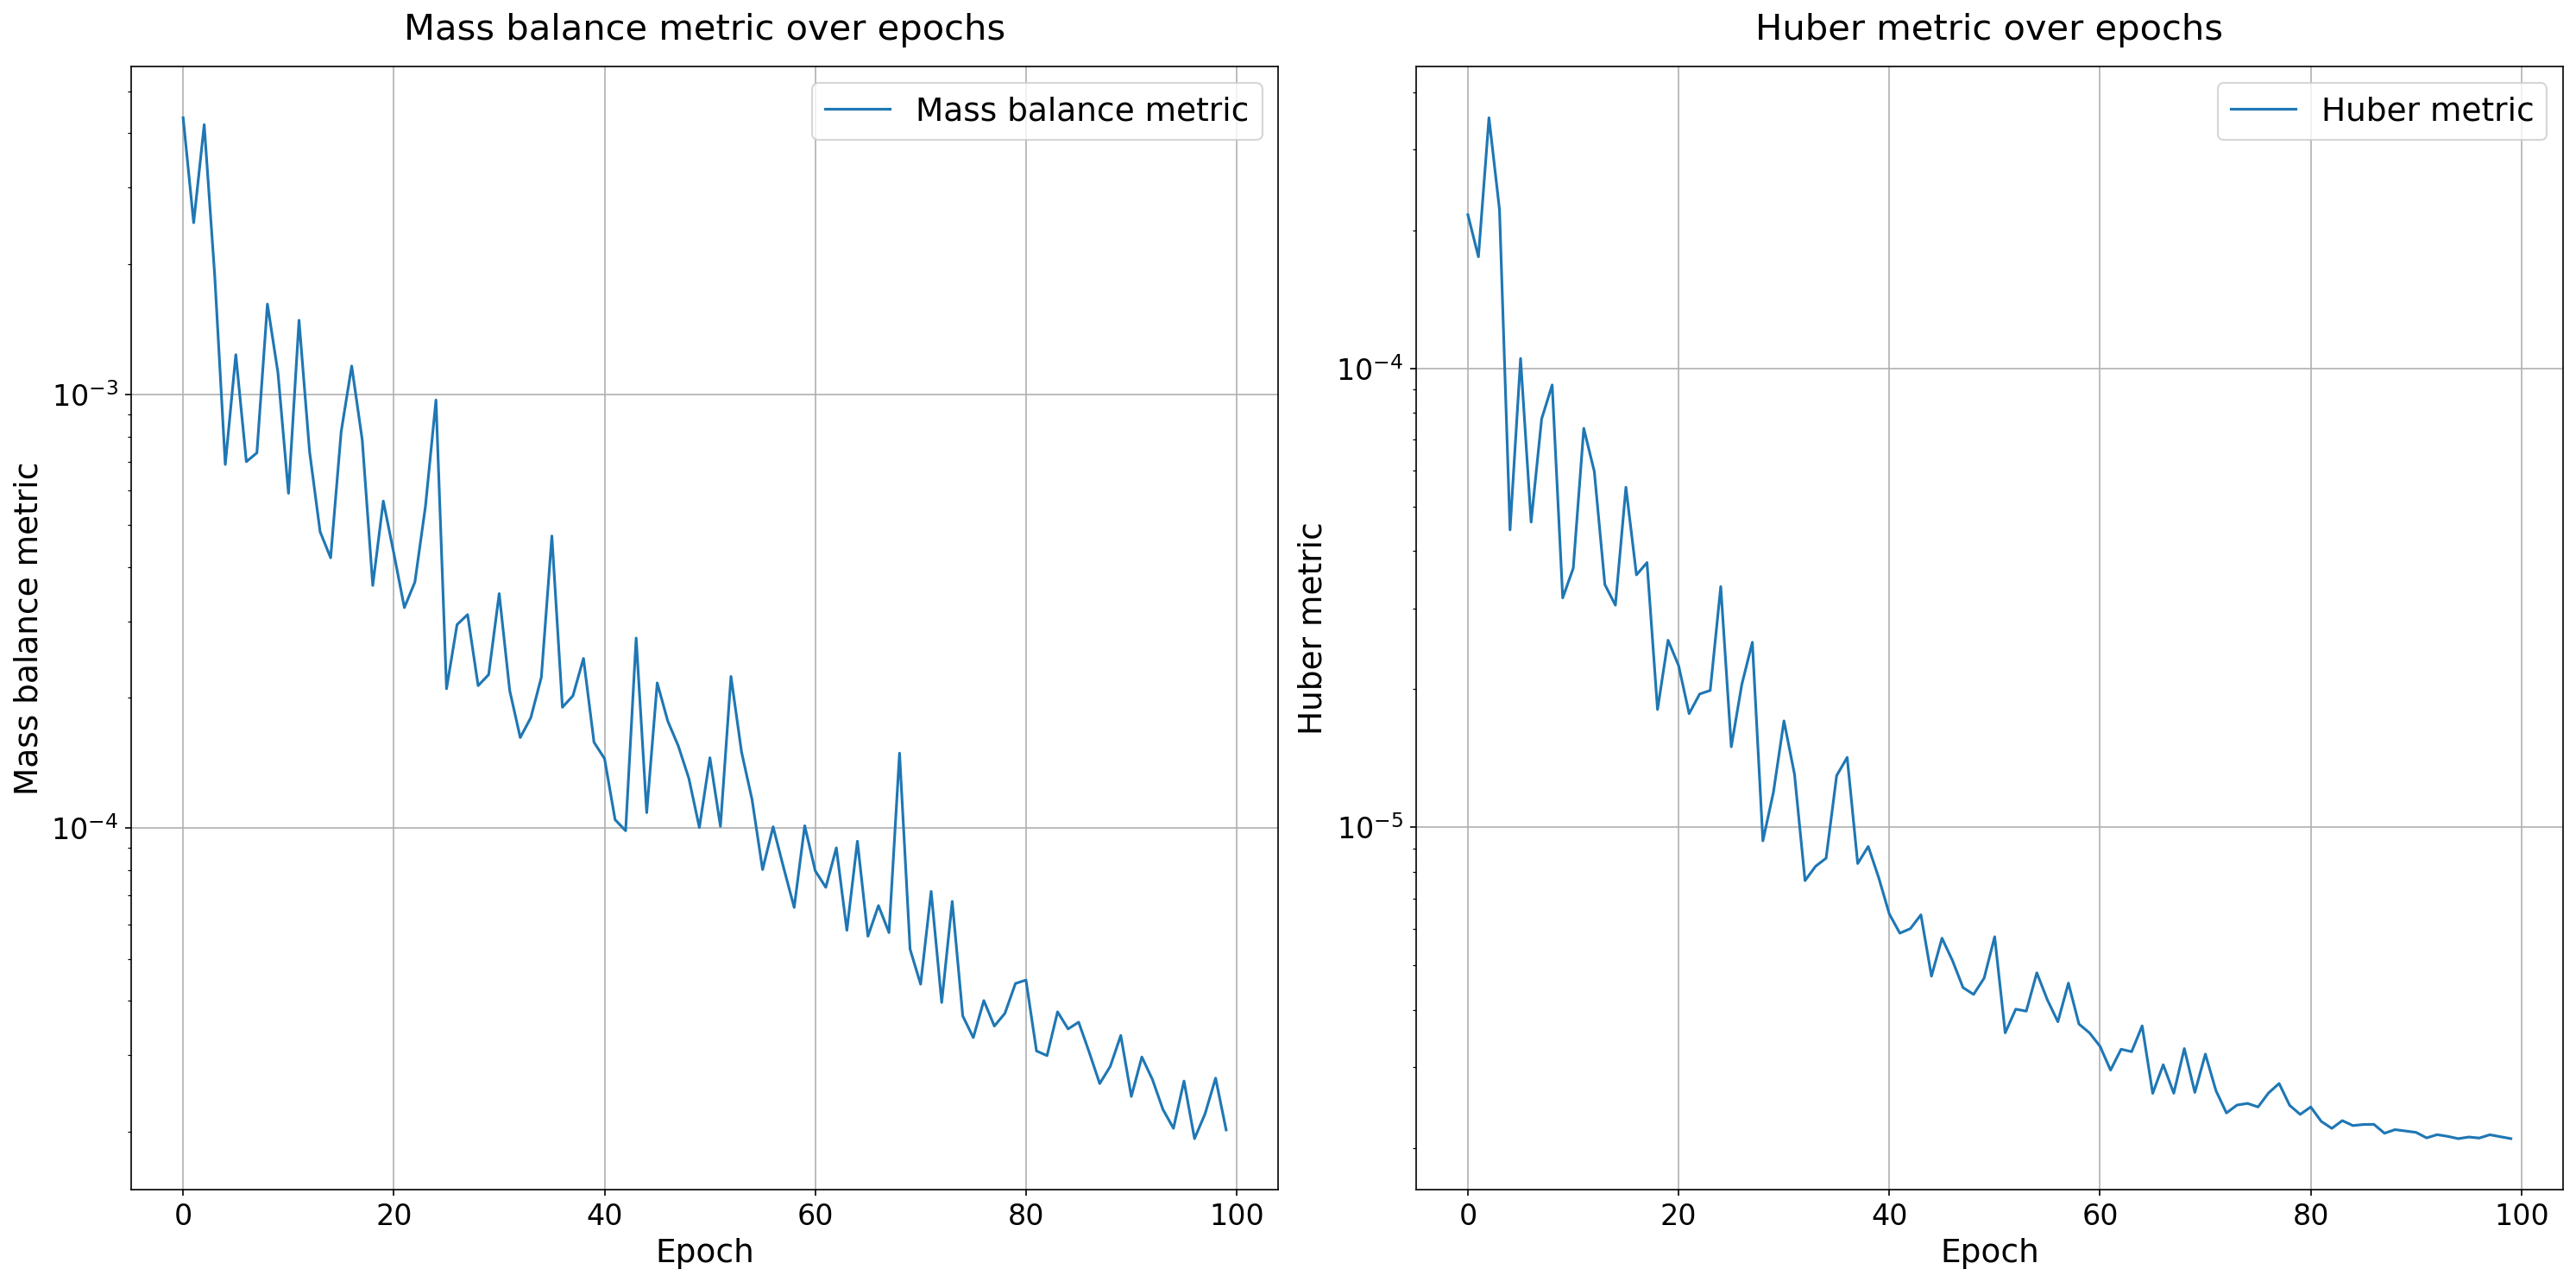

In [25]:
plot_metrics(history)

## Test Mass Balance

### Valid and invalid region in the grid

To check how high the proportion of cells that fulfil the mass balance is, we first output the corresponding proportion. Furthermore, we differentiate between how many cells from the non-reactive area (class 0) and reactive area (class 1) fulfil the mass balance. It is to be expected that the model can predict cells in which not much happens, i.e. in which the reaction has not yet taken place, better than the complex chemistry.

In [40]:
results = mass_balance_evaluation(model, X_train, preprocess)
mass_balance_ratio(results, threshold=1e-5)

14175/14175 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


{'overall': 0.8228659611992946,
 'class_0': 0.8640359305004109,
 'class_1': 0.001662433618102055}

Next, we want to visualise which cells fulfil the mass balance depending on the respective iteration. To do this, we must first take our original dataset and scale it (X_train cannot be used because it is also shuffled due to the division into training and testing) in order to then predict it with our model.

In [ ]:
# scale our original data to use the trained model and predict the mass balance
input_scaled = preprocess.scaler_X.transform(X.iloc[:, X.columns != "Class"])
input_scaled = pd.concat([pd.DataFrame(input_scaled, columns=X.columns[X.columns != "Class"]), X["Class"]], axis=1)
results_origin = mass_balance_evaluation(model, input_scaled, preprocess)

# extract the mass balance for the grid per iteration
mass_balance_per_iteration = []
for i in range(0, int(len(results_origin) / 2500)):
    mass_balance_per_iteration.append(
        results_origin["mass_balance"][(i * 2500) : ((i + 1) * 2500)]
        )

19688/19688 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


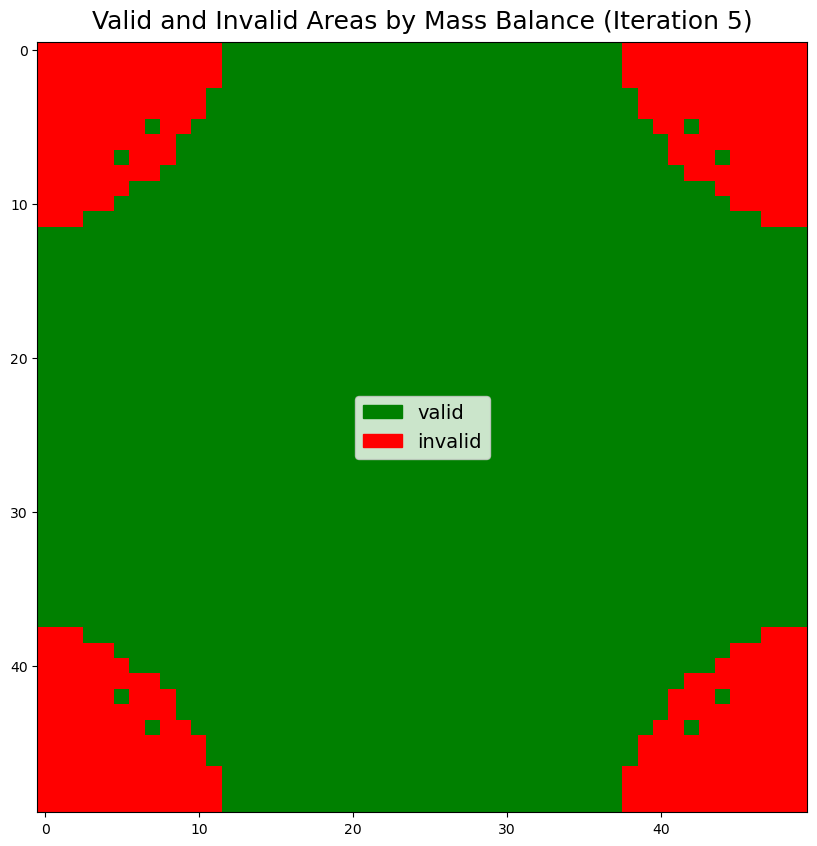

In [ ]:
def plot_mass_balance(X, iteration=80):
    
    bounds = [0, 1e-5, 1e-4]
    colors = ["green", "red"]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create plot
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.imshow(
        np.array(mass_balance_per_iteration[iteration]).reshape(50, 50),
        cmap=cmap,
        norm=norm,
    )

    # Manual legend with colored boxes
    legend_patches = [
        mpatches.Patch(color="green", label="valid"),
        mpatches.Patch(color="red", label="invalid"),
    ]

    ax.legend(handles=legend_patches, loc="center", fontsize=14)
    ax.set_title(
        f"Valid and Invalid Areas by Mass Balance (Iteration {iteration})", fontsize=18, pad=10
    )

    plt.show()


plot_mass_balance(results_origin, iteration=5)

As expected, the reactive regions of the model do not fulfil the mass balance threshold of $10^{-5}$ and are therefore invalid.

### Prediction vs Results in comparison with the mass balance

Next, we look at how the prediction and the actual result behave for selected cells and compare this with the corresponding mass balance. To do this, we plot the above values for three different cells (1, 43 and 1250). Cell 1 is the cell where barium is added, cell 43 is a little further away and should rise with a corresponding delay and cell 1250 is relatively in the centre and should therefore hardly react.

In [65]:
def plot_predictions_and_mass_balance(model, cell_indices, species="Ba", iterations=250):
    fig, axes = plt.subplots(2, len(cell_indices), figsize=(20, 10), dpi=150)

    for j, cell_offset in enumerate(cell_indices):
        y_design = []
        y_results = []

        df_design_transformed_scaled = preprocess.scaler_X.transform(df_design[species_columns])
        df_results_transformed_scaled = preprocess.scaler_y.transform(df_results[species_columns])

        for i in range(0, iterations):
            idx = i * 50 * 50 + cell_offset - 1
            y_design.append(df_design_transformed_scaled.iloc[idx, :])
            y_results.append(df_results_transformed_scaled.iloc[idx, :])

        y_design = pd.DataFrame(y_design, columns=species_columns)
        y_results = pd.DataFrame(y_results, columns=species_columns)

        prediction = model.predict(y_design)
        prediction = pd.DataFrame(prediction, columns=y_results.columns)

        y_design_back = pd.DataFrame(preprocess.scaler_y.inverse_transform(y_design), columns=species_columns)
        y_results_back = pd.DataFrame(preprocess.scaler_y.inverse_transform(y_results), columns=species_columns)
        prediction_back = pd.DataFrame(preprocess.scaler_X.inverse_transform(prediction), columns=species_columns)

        # Plot predictions and results
        axes[0, j].plot(np.arange(0, iterations), y_results_back[species], label="Results")
        axes[0, j].plot(np.arange(0, iterations), prediction_back[species], label="Prediction")
        axes[0, j].legend()
        axes[0, j].set_xlabel("Iteration", fontsize=12, labelpad=10)
        axes[0, j].set_ylabel("Concentration", fontsize=12)
        axes[0, j].set_title(f"{species} concentration profile in cell {cell_offset}", fontsize=14, pad=10)
        axes[0, j].grid()
        axes[0, j].legend(fontsize=12)

        # Calculate and plot mass balance
        mass_balance = np.abs(
            (prediction_back["Ba"] + prediction_back["Barite"]) - (y_results_back["Ba"] + y_results_back["Barite"])
        ) + np.abs(
            (prediction_back["Sr"] + prediction_back["Celestite"]) - (y_results_back["Sr"] + y_results_back["Celestite"])
        )
        axes[1, j].plot(np.arange(0, iterations), mass_balance)
        axes[1, j].set_xlabel("Iteration", fontsize=14, labelpad=10)
        axes[1, j].set_title(f"Mass Balance in cell {cell_offset}", fontsize=14, pad=10)
        axes[1, j].axhline(y=1e-5, color="r", linestyle="--", label="Threshold 1e-5")
        axes[1, j].set_yscale("log")
        axes[1, j].grid()
        axes[1, j].legend(fontsize=12)

    plt.tight_layout()
    plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


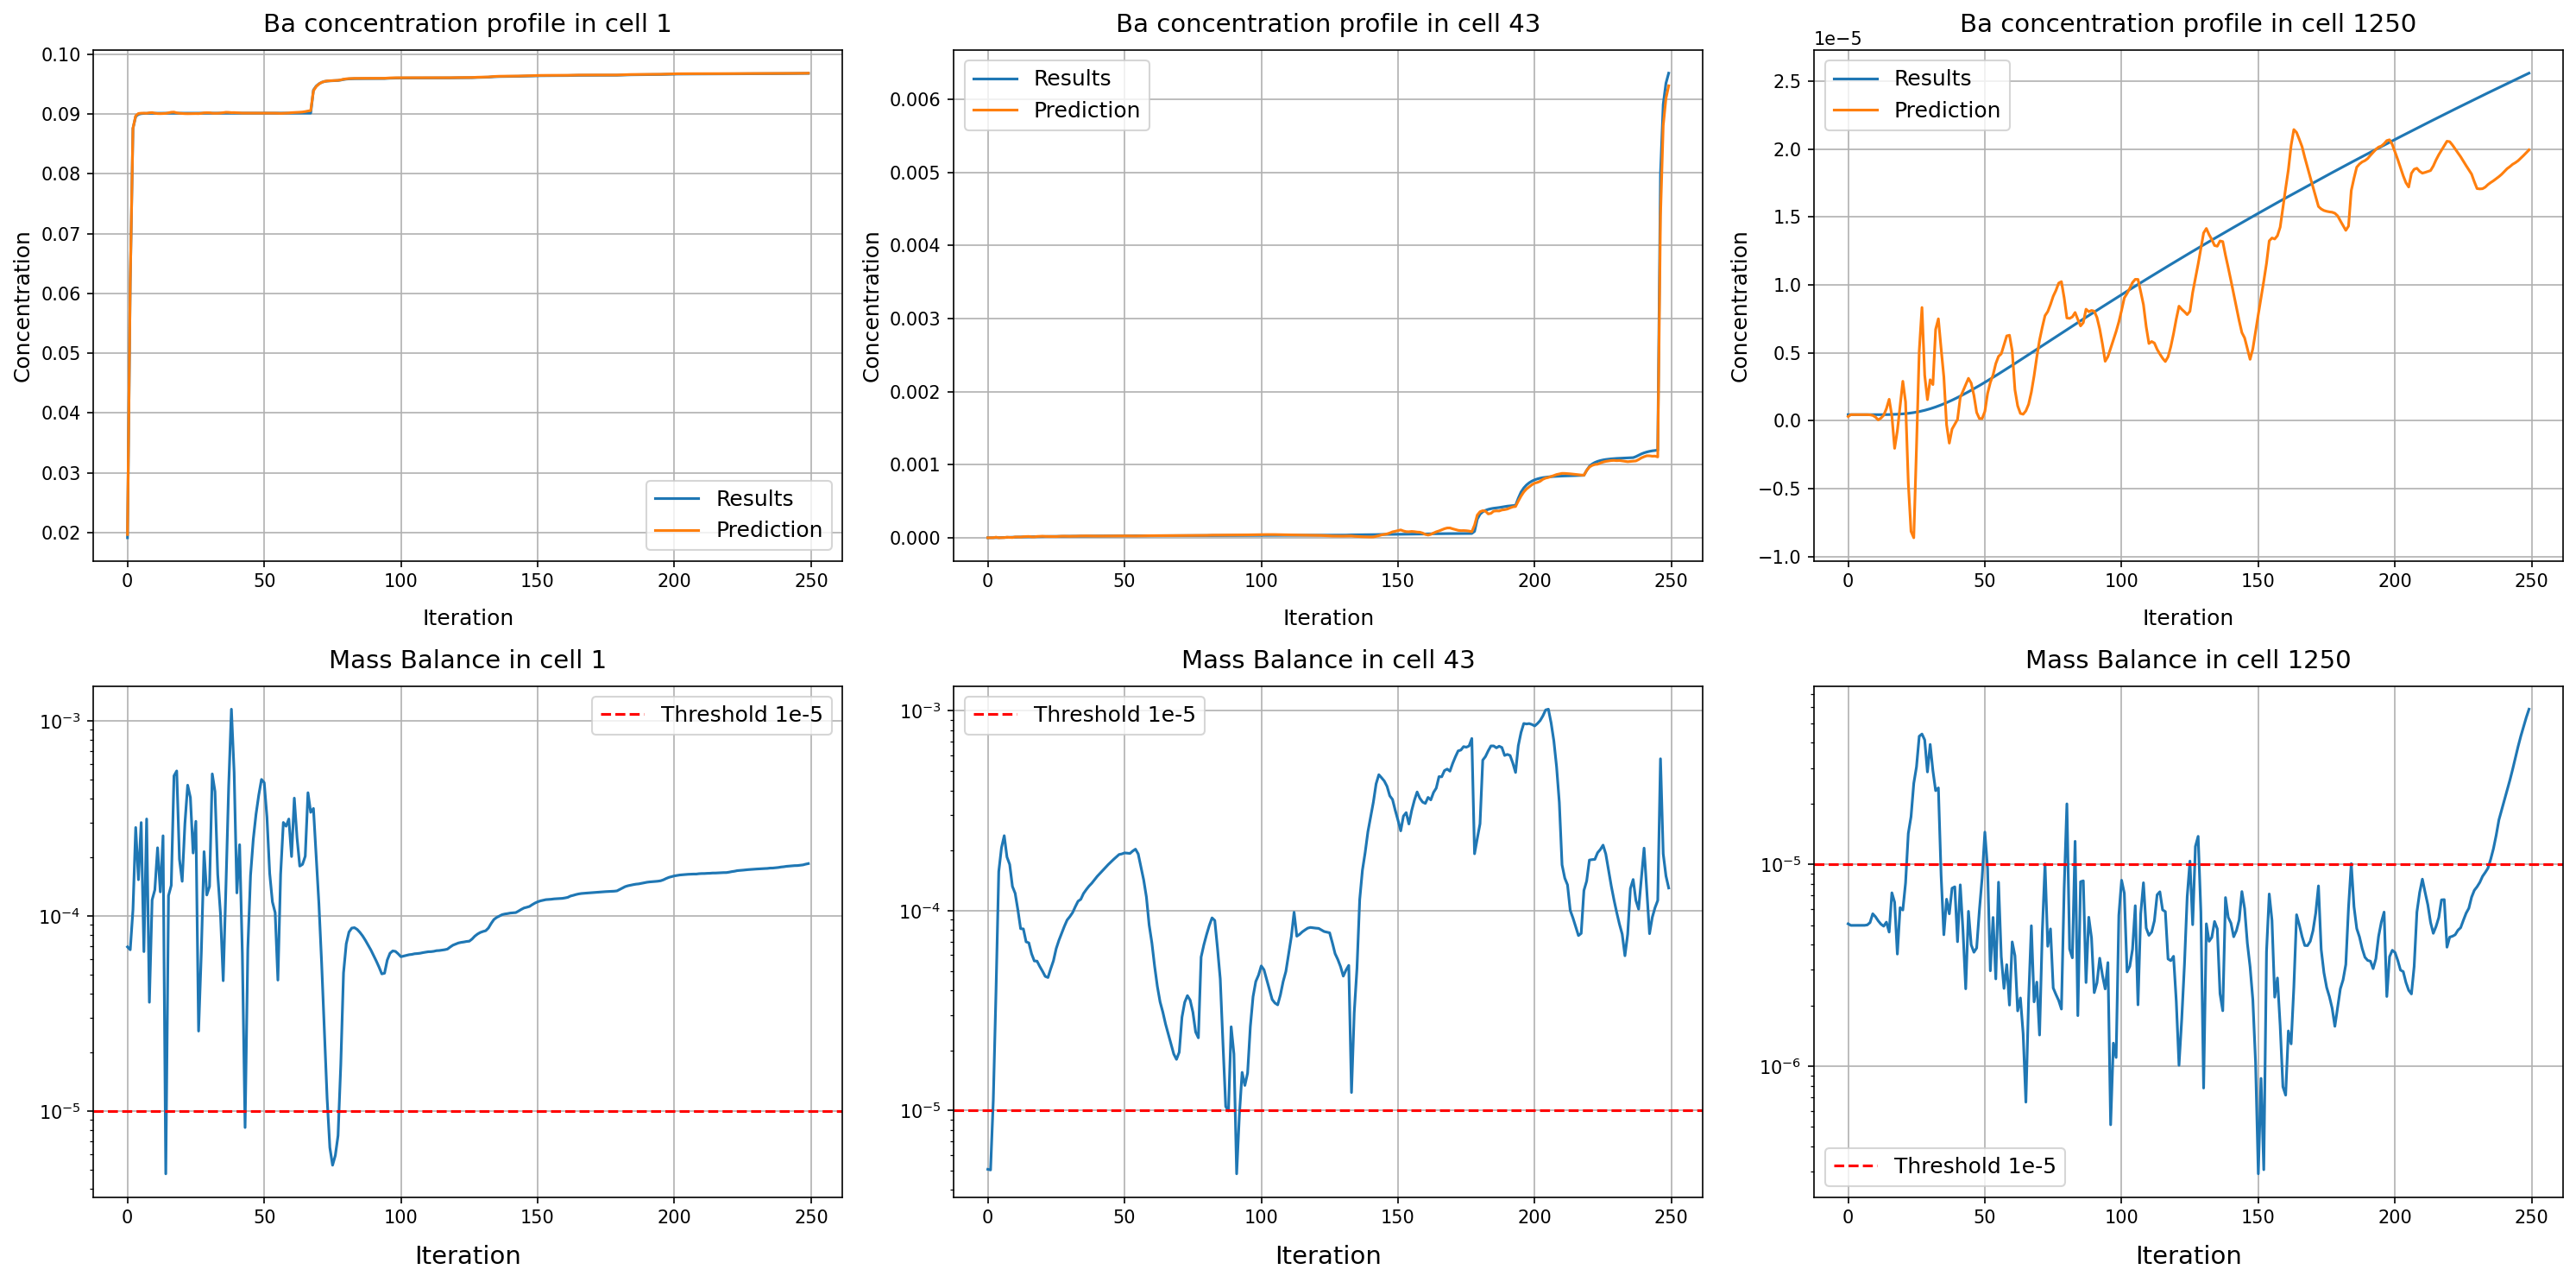

In [64]:
plot_predictions_and_mass_balance(model, [1, 43, 1250], species="Ba", iterations=250)

The result is as expected. In cell 1, the barium concentration rises abruptly and remains relatively stable over time. In cell 43, barium only increases by diffusion after approx. 175 iterations and in cell 1250 the barium concentration remains de facto constant (note the scale!). Looking at the mass balance, it quickly becomes clear that in most cases this is also only fulfilled in the non-reactive cell 1250.

## Test the model

Finally, we print out the respective metrics (total loss, Huber loss and mass balance) for the corresponding test data set (X_test) and again see that all loss metrics perform significantly better for the non-reactive case than for the reactive case.

In [66]:
def test_model(model, X_test, y_test):
    
    X_test.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    all = model.evaluate(X_test.loc[:, X_test.columns != "Class"], y_test.loc[:, y_test.columns != "Class"])
    class_0 = model.evaluate(X_test[X_test["Class"] == 0].iloc[:, X_test.columns != "Class"], y_test[X_test["Class"] == 0].iloc[:, y_test.columns != "Class"])
    class_1 = model.evaluate(
    X_test[X_test["Class"] == 1].iloc[:, :-1], y_test[X_test["Class"] == 1].iloc[:, :-1])
    
    print("metric all data: ", all)
    print("metric class 0: ", class_0)
    print("metric class 1: ", class_1)

In [67]:
test_model(model, X_test, y_test)

3938/3938 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - huber: 3.0615e-06 - loss: 1.0808e-05 - mass_balance: 1.9887e-05
3747/3747 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - huber: 2.1582e-06 - loss: 5.5914e-06 - mass_balance: 1.0110e-05
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - huber: 2.0602e-05 - loss: 1.1211e-04 - mass_balance: 2.0973e-04
metric all data:  [1.0805763849930372e-05, 3.288454536232166e-06, 1.980934939638246e-05]
metric class 0:  [5.6999147091119085e-06, 2.409552052995423e-06, 1.0236796697427053e-05]
metric class 1:  [0.00011092334898421541, 2.0596029571606778e-05, 0.00020741194020956755]
